In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
import yfinance as yf 

from scipy.optimize import fmin
from nelson_siegel_svensson import NelsonSiegelCurve as NS
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve as NSS
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols

from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
filterwarnings(action='ignore')

In [166]:
### Get Data

yield_curve = {
'DGS1MO' : '1M',
'DGS3MO' : '3M',
'DGS6MO' : '6M',
'DGS1'   : '1Y', 
'DGS2'   : '2Y',  
'DGS3'   : '3Y',  
'DGS5'   : '5Y',  
'DGS7'   : '7Y',  
'DGS10'  : '10Y', 
'DGS20'  : '20Y', 
'DGS30'  : '30Y', 
}

YieldCurve = web.DataReader(yield_curve.keys(), 'fred', '18540101', '20231219')
YieldCurve = YieldCurve.rename(columns=yield_curve)

tickers = ['^GSPC','^DJI','^IXIC','TLT']
names = ['SP500','DowJones','Nasdaq','TLT']

price_df = yf.download(tickers, interval='1d', period='max')['Adj Close'].rename(dict(zip(tickers,names)),axis=1)

[*********************100%***********************]  4 of 4 completed


## Sources: 

https://towardsdatascience.com/decomposing-predicting-the-euro-yield-curve-b3ad1670fdbb

https://bjerring.github.io/bonds/2019/10/16/the-yield-curve-and-its-components.html

https://medium.com/@appravi18/yield-curve-modeling-part-1-f25cd45ee546

https://medium.com/@appravi18/yield-curve-modeling-part-2-12820e9839d4


https://github.com/bernhard-pfann/pca-yield-curve-analytics/blob/main/scripts/main.ipynb

### Download and wrangle Market Yield Curve Data

In [167]:
YieldCurve.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16166 entries, 1962-01-02 to 2023-12-19
Freq: B
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1M      5600 non-null   float64
 1   3M      10576 non-null  float64
 2   6M      10576 non-null  float64
 3   1Y      15478 non-null  float64
 4   2Y      11886 non-null  float64
 5   3Y      15478 non-null  float64
 6   5Y      15478 non-null  float64
 7   7Y      13608 non-null  float64
 8   10Y     15478 non-null  float64
 9   20Y     13789 non-null  float64
 10  30Y     11708 non-null  float64
dtypes: float64(11)
memory usage: 1.5 MB


In [168]:
def clean_YC(YC, fill_missing_mat=False):
    '''wrangle yield curve data in format of:
       columns = maturities (in years, numeric)
       rows = time-series observations of yields across maturities at a particular date
       values = yields in decimals, missing yields filled with linear interpolation across maturities
    '''
    YC = YC / 100
    mat_labels = YC.columns
    numeric_mats = [int(mat[:-1]) if 'Y' in mat else int(mat[:-1])/12 for mat in mat_labels]
    YC = YC.rename(dict(zip(mat_labels, numeric_mats)), axis=1)
    
    if fill_missing_mat:
        missing_mats = [missing for missing in range(1,max(numeric_mats)+1) if missing not in numeric_mats]
        YC[missing_mats] = np.nan
        YC = YC.sort_index(axis=1)
        YC = YC.apply(lambda x: x.interpolate(method="polynomial", order=1), axis=1).dropna()
        YC.columns = np.round(YC.columns, 2)
        return YC
        
    YC = YC.apply(lambda x: x.interpolate(method="polynomial", order=1), axis=1).dropna()
    #YC = YC.rename(dict(zip(numeric_mats, mat_labels)), axis=1)
    YC.columns = np.round(YC.columns, 2)
    return YC

def fit_nss(y):
    '''fit cleaned yield curve data into NSS OLS, smoothens the yield curve with regression fit'''
    mat = y.index.values
    curve_fit, status = calibrate_nss_ols(mat, y.values)

    β0 = curve_fit.beta0
    β1 = curve_fit.beta1
    β2 = curve_fit.beta2
    β3 = curve_fit.beta3
    λ0 = curve_fit.tau1
    λ1 = curve_fit.tau2
    nss = (
        β0 + β1*((1 - np.exp(-mat/λ0)) / (mat/λ0)) 
           + β2*(((1 - np.exp(-mat/λ0)) / (mat/λ0)) - np.exp(-mat/λ0)) 
           + β3*(((1 - np.exp(-mat/λ1)) / (mat/λ1)) - np.exp(-mat/λ1))
    )
    return nss, [β0, β1, β2, β3, λ0, λ1]

In [169]:
# NSS_fit: yield curve filled in with interpolated missing maturities, then fitted NSS ols
error_dates = []
full_YC_T = clean_YC(YieldCurve, fill_missing_mat=True).T
NSS_fit = full_YC_T.copy()
NSS_coefs = pd.DataFrame(index=['β0','β1','β2','β3','λ0','λ1'], columns=NSS_fit.columns)
for col in tqdm(NSS_fit):
    try:
        fitted, coefs = fit_nss(NSS_fit[col])
        NSS_fit[col] = fitted
        NSS_coefs[col] = coefs
    except:
        error_dates.append(col)
        
NSS_fit = NSS_fit.T
NSS_coefs = NSS_coefs.T.dropna()
print(error_dates)
NSS_fit.head(3)

  0%|          | 0/33 [00:00<?, ?it/s]

[Timestamp('2007-08-20 00:00:00'), Timestamp('2022-04-12 00:00:00'), Timestamp('2022-06-15 00:00:00'), Timestamp('2022-06-27 00:00:00'), Timestamp('2022-07-01 00:00:00'), Timestamp('2022-07-20 00:00:00'), Timestamp('2022-08-17 00:00:00'), Timestamp('2022-08-25 00:00:00'), Timestamp('2022-09-06 00:00:00'), Timestamp('2022-09-09 00:00:00'), Timestamp('2022-09-12 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-18 00:00:00'), Timestamp('2022-10-24 00:00:00')]


,0.08,0.25,0.50,1.00,2.00,3.00,4.00,5.00,6.00,7.00,...,21.00,22.00,23.00,24.00,25.00,26.00,27.00,28.00,29.00,30.00
DATE,,,,,,,,,,,,,,,,,,,,,
2001-07-31,0.035358,0.035431,0.035631,0.036294,0.038245,0.040505,0.042724,0.044745,0.046511,0.048018,...,0.055108,0.055230,0.055338,0.055434,0.055519,0.055595,0.055664,0.055726,0.055782,0.055833
2001-08-01,0.035208,0.035351,0.035644,0.036452,0.038584,0.040930,0.043182,0.045207,0.046962,0.048450,...,0.055336,0.055451,0.055552,0.055642,0.055721,0.055791,0.055855,0.055912,0.055964,0.056011
2001-08-02,0.035059,0.035300,0.035719,0.036731,0.039116,0.041589,0.043895,0.045934,0.047682,0.049153,...,0.055812,0.055920,0.056013,0.056096,0.056168,0.056233,0.056291,0.056343,0.056390,0.056433


In [170]:
# wrangle YC data (no filling of missing maturities, only missing yields linear-interpolated)
yc = clean_YC(YieldCurve)

### PCA scree plot on Yield Curve

array([83.7, 15. ,  1.1,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

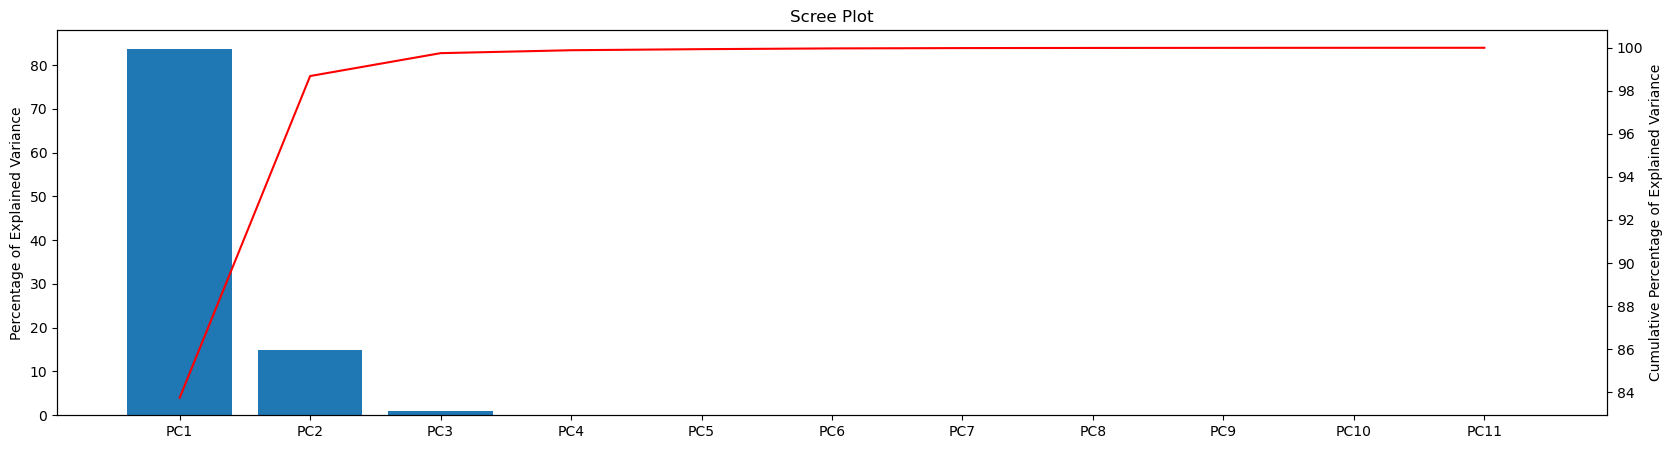

In [171]:
# must standardize YC for each maturities(features) before PCA decomposition
scaler = StandardScaler()
scaled_YC = scaler.fit_transform(yc)

# fit PCA
pca = PCA(n_components=len(yc.columns))
YC_pca = pca.fit_transform(scaled_YC)
PCA_labels = [f'PC{n}' for n in range(1,len(yc.columns)+1)]
YC_pca = pd.DataFrame(YC_pca).set_axis(PCA_labels, axis=1)

# Scree plot
per_var = pca.explained_variance_ratio_ * 100
fig,ax = plt.subplots(figsize=(20,5))
ax1 = ax.twinx()
ax.bar(x=PCA_labels, height=per_var)
ax1.plot(PCA_labels, pca.explained_variance_ratio_.cumsum()*100, c='red')
ax.set_ylabel('Percentage of Explained Variance')
ax1.set_ylabel('Cumulative Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot');
per_var.round(1)

### Explore PCA outputs: shaping factors, loadings, residuals

In [172]:
def fit_PCA(yc, n_components=None):
    # must standardize YC for each maturities(features) before PCA decomposition
    scaler = StandardScaler()
    scaled_YC = scaler.fit_transform(yc)
    
    if n_components==None:
        # fit PCA
        pca = PCA(n_components=len(yc.columns), random_state=42)
        PCA_labels = [f'PC{n}' for n in range(1,len(yc.columns)+1)]
    else: 
        pca = PCA(n_components=n_components, random_state=42)
        PCA_labels = [f'PC{n}' for n in range(1,n_components+1)]
        
    YC_pca = pca.fit_transform(scaled_YC)
    YC_pca = pd.DataFrame(YC_pca).set_axis(PCA_labels, axis=1)
    # get loadings for pca
    factor_load = pd.DataFrame(pca.components_.T, index=yc.columns, columns=PCA_labels)
    return YC_pca, factor_load

def get_PCA_pred(yc_train, yc_test, resid=False, n_components=3, PC1_shift=0, PC2_shift=0, PC3_shift=0):
    # instantiate PCA, scaler
    pca = PCA(n_components=n_components, random_state=42)
    scaler = StandardScaler()
    
    # fit yc_train (in-of-sample PCA)
    scaled_yc_train = scaler.fit_transform(yc_train)
    PCA_train = pca.fit_transform(scaled_yc_train)[:,:n_components] # YC_pca
    PCA_train[:,0] += PC1_shift
    PCA_train[:,1] += PC2_shift
    PCA_train[:,2] += PC3_shift
    
    # factor_load
    factor_load = pca.components_[:n_components,:]
    # reverse transformation back to get PCA-implied yield curves (predicted by 3 components)
    reconstructed_train = pd.DataFrame(data=scaler.inverse_transform(np.dot(PCA_train, factor_load)),
                                       columns=yc_train.columns, index=yc_train.index)
    
    # pred yc_test (out-of-sample PCA)
    scaled_yc_test = scaler.transform(yc_test)
    PCA_test = pca.transform(scaled_yc_test)[:,:n_components]
    # for stress testing YC
    PCA_test[:,0] += PC1_shift
    PCA_test[:,1] += PC2_shift
    PCA_test[:,2] += PC3_shift
    reconstructed_test = pd.DataFrame(data=scaler.inverse_transform(np.dot(PCA_test, factor_load)),
                                      columns=yc_test.columns, index=yc_test.index)
    if resid:
        resid_train = yc_train - reconstructed_train
        resid_test = yc_test - reconstructed_test
        return resid_train, resid_test, factor_load
    
    return reconstructed_train, reconstructed_test, factor_load
    

def eigen_portfolios(yc):
    n_components = 3
    PCA_res = pca.transform(scaler.fit_transform(yc))[:,:n_components] # YC_pca
    factor_load = pca.components_[:n_components,:] # factor_load
    PCA_labels = [f'PC{n}' for n in range(1,n_components+1)]
    topPorfolios = pd.DataFrame(factor_load, columns=yc.columns, index=PCA_labels)
    # loading matrix?: pca.components_.T * np.sqrt(pca.explained_variance_)
    eigen_portfolios = topPorfolios.div(topPorfolios.sum(1),axis=0)
    return eigen_portfolios.T

def std_ser(ser):
    scaler = StandardScaler()
    return scaler.fit_transform(ser.values.reshape(-1, 1))  

def TS_train_test_split(yc, test_size=0.2):
    cutoff = int(len(yc)*test_size)
    yc_train = yc.iloc[:-cutoff]
    yc_test = yc.iloc[-cutoff:]
    print(f'train data: {yc_train.index[0]} ~ {yc_train.index[-1]}, ({len(yc_train)})')
    print(f'test data: {yc_test.index[0]} ~ {yc_test.index[-1]}, ({len(yc_test)})')
    print(f'Total len: {len(yc)}, train + test = {len(yc_train) + len(yc_test)}')
    return yc_train, yc_test

#### Fit PCA on NSS fitted yield curve (with interpolated missing maturities)

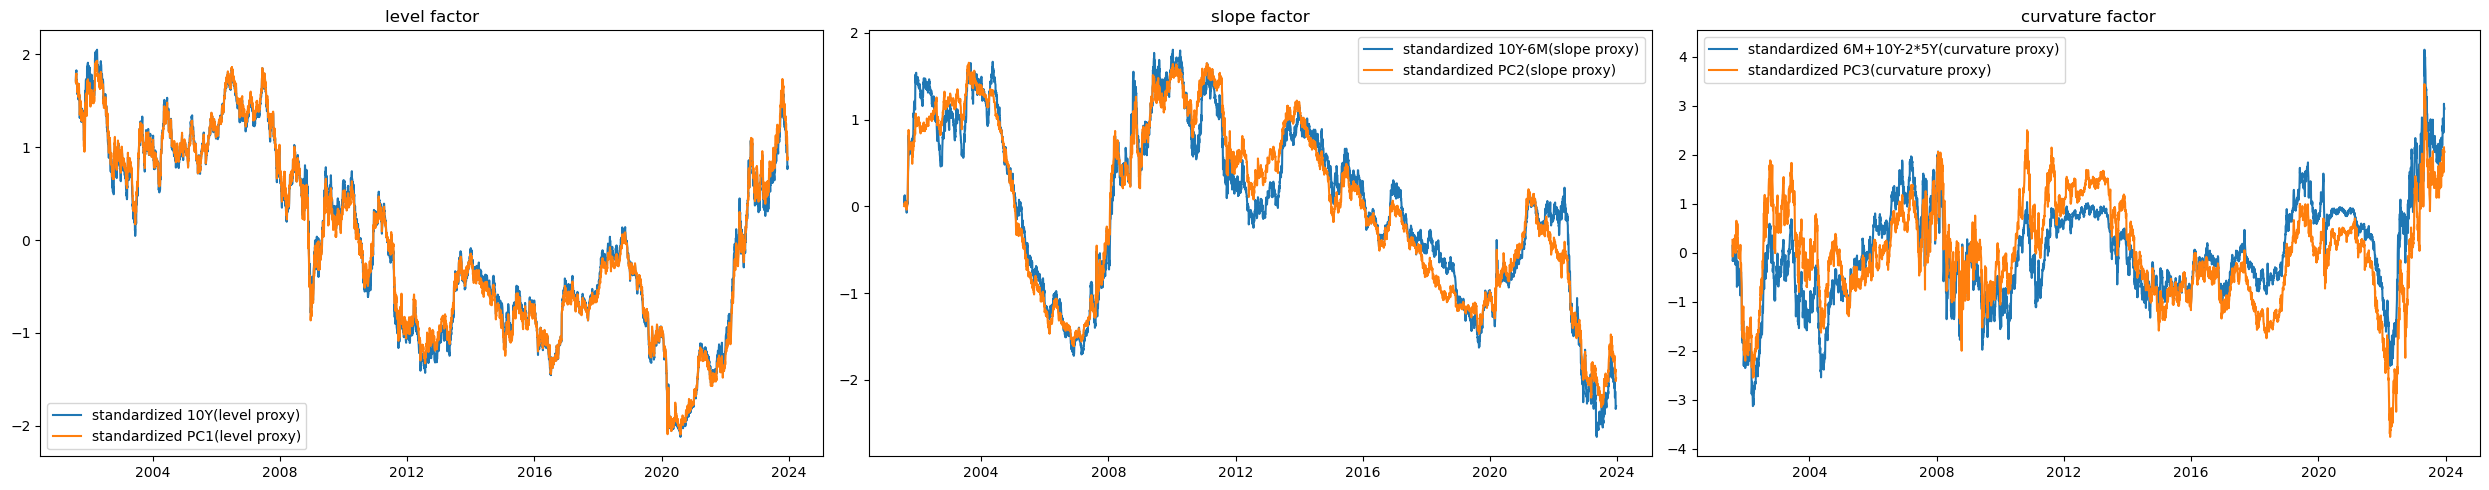

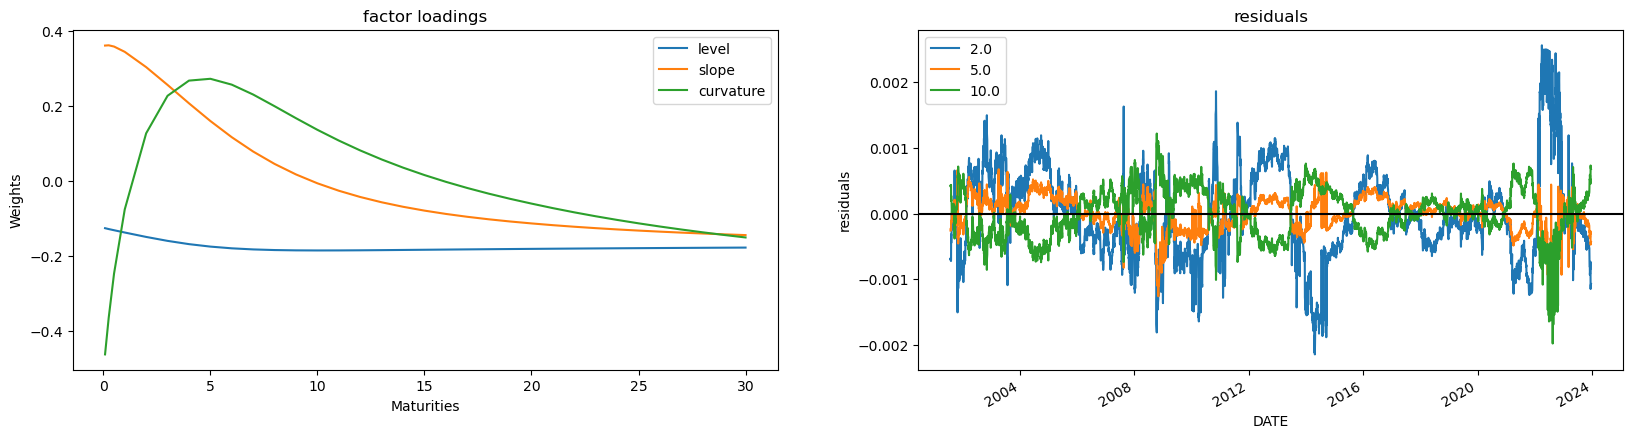

In [173]:
YC_pca, factor_load = fit_PCA(NSS_fit)
# Scaled principal components
pc_1 = std_ser(YC_pca["PC1"])*-1
pc_2 = std_ser(YC_pca["PC2"])*-1
pc_3 = std_ser(YC_pca["PC3"])*-1

# Classical yield curve factors
level = std_ser(NSS_fit[10])
slope = std_ser(NSS_fit[10] - NSS_fit[0.5])
curvature = std_ser(NSS_fit[0.5] + NSS_fit[10] - 2*NSS_fit[5])
classical_factors = pd.DataFrame(index=NSS_fit.index)
classical_factors['level'] = level
classical_factors['slope'] = slope
classical_factors['curvature'] = curvature

fig,ax = plt.subplots(1,3, figsize=(25,5))
ax[0].plot(NSS_fit.index, level, label='standardized 10Y(level proxy)');
ax[0].plot(NSS_fit.index, pc_1, label='standardized PC1(level proxy)')
ax[0].legend();
ax[0].set_title('level factor')

ax[1].plot(NSS_fit.index, slope, label='standardized 10Y-6M(slope proxy)');
ax[1].plot(NSS_fit.index, pc_2, label='standardized PC2(slope proxy)')
ax[1].legend();
ax[1].set_title('slope factor')

ax[2].plot(NSS_fit.index, curvature, label='standardized 6M+10Y-2*5Y(curvature proxy)');
ax[2].plot(NSS_fit.index, pc_3, label='standardized PC3(curvature proxy)')
ax[2].legend();
ax[2].set_title('curvature factor')
plt.tight_layout();

fig,ax = plt.subplots(1,2, figsize=(20,5))
(
    factor_load[['PC1','PC2','PC3']]
    .set_axis(['level','slope','curvature'],axis=1)
    .plot(xlabel='Maturities', ylabel='Weights', ax=ax[0])
)
ax[0].set_title('factor loadings')

resid, _, _ = get_PCA_pred(NSS_fit, NSS_fit, resid=True, n_components=3)
resid[[2,5,10]].plot(ax=ax[1], ylabel='residuals')
ax[1].set_title('residuals')
ax[1].axhline(0, c='black');


#### Fit PCA on yield curve data (no filling of missing maturities, only missing yields interpolated)

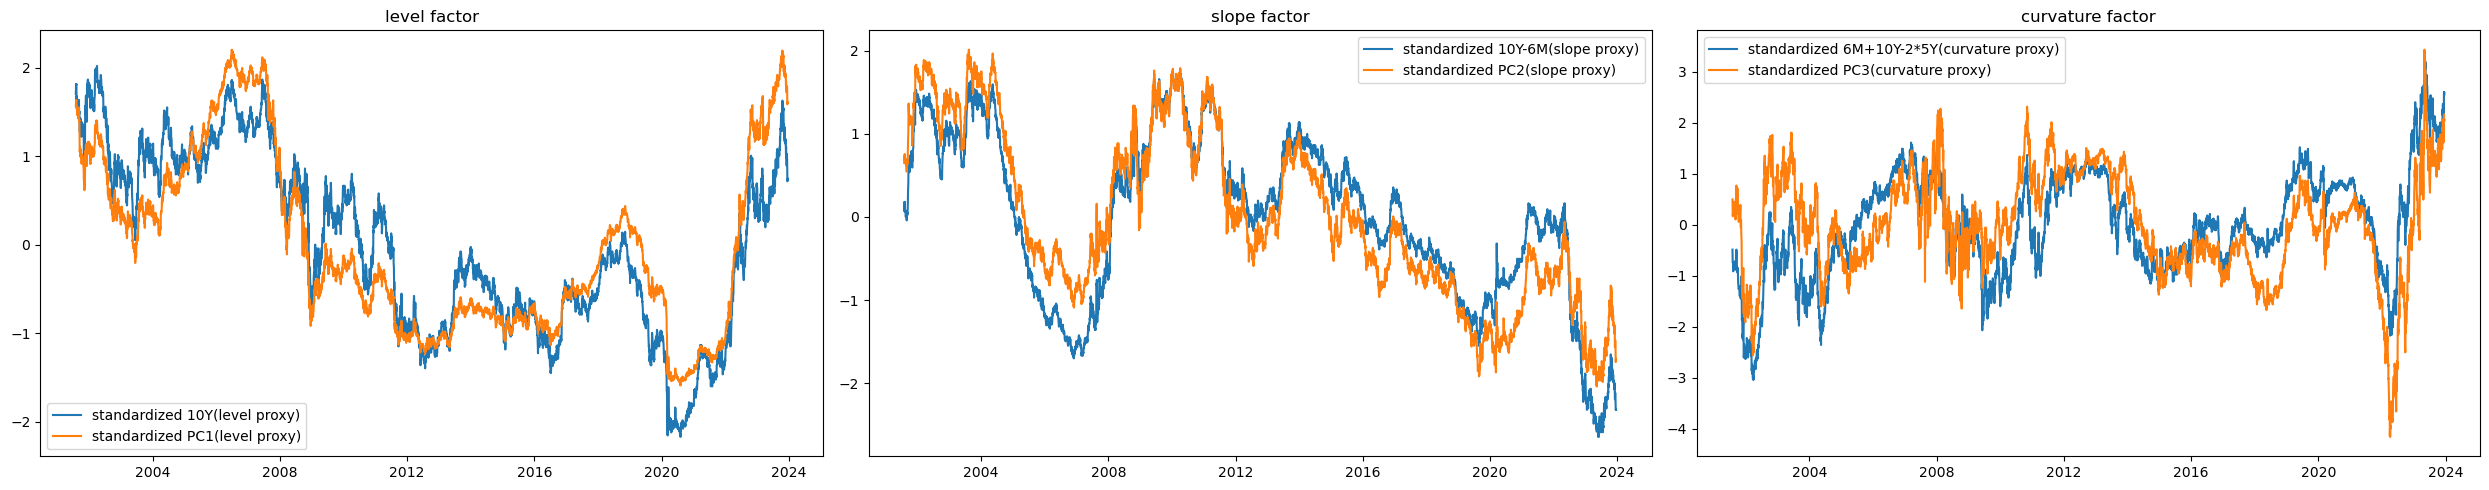

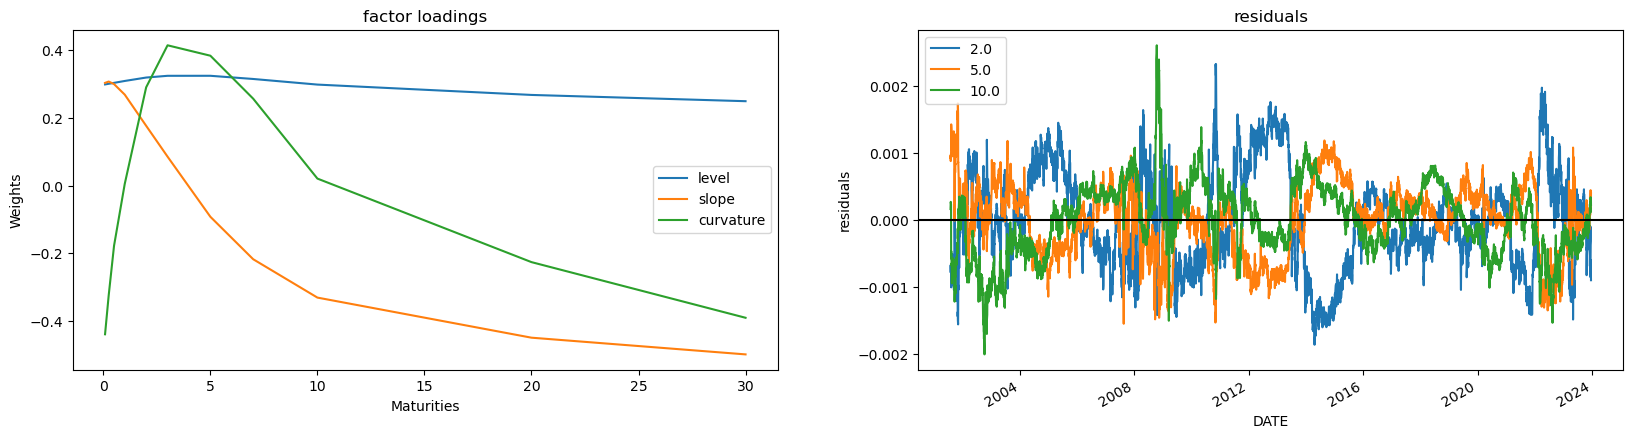

In [174]:
level = std_ser(yc[10])
slope = std_ser(yc[10] - yc[0.5])
curvature = std_ser(yc[0.5] + yc[10] - 2*yc[5])
classical_factors = pd.DataFrame(index=yc.index)
classical_factors['level'] = level
classical_factors['slope'] = slope
classical_factors['curvature'] = curvature

YC_pca, factor_load = fit_PCA(yc)
# Scaled principal components
pc_1 = std_ser(YC_pca["PC1"])
pc_2 = std_ser(YC_pca["PC2"])*-1
pc_3 = std_ser(YC_pca["PC3"])*-1

fig,ax = plt.subplots(1,3, figsize=(25,5))
ax[0].plot(yc.index, level, label='standardized 10Y(level proxy)');
ax[0].plot(yc.index, pc_1, label='standardized PC1(level proxy)')
ax[0].legend();
ax[0].set_title('level factor')

ax[1].plot(yc.index, slope, label='standardized 10Y-6M(slope proxy)');
ax[1].plot(yc.index, pc_2, label='standardized PC2(slope proxy)')
ax[1].legend();
ax[1].set_title('slope factor')

ax[2].plot(yc.index, curvature, label='standardized 6M+10Y-2*5Y(curvature proxy)');
ax[2].plot(yc.index, pc_3, label='standardized PC3(curvature proxy)')
ax[2].legend();
ax[2].set_title('curvature factor')
plt.tight_layout();

fig,ax = plt.subplots(1,2, figsize=(20,5))
(
    factor_load[['PC1','PC2','PC3']]
    .set_axis(['level','slope','curvature'],axis=1)
    .plot(xlabel='Maturities', ylabel='Weights', ax=ax[0])
)
ax[0].set_title('factor loadings')

resid, _, _ = get_PCA_pred(yc, yc, resid=True, n_components=3)
resid[[2,5,10]].plot(ax=ax[1], ylabel='residuals')
ax[1].set_title('residuals')
ax[1].axhline(0, c='black');

### Understanding PC factors: PC1, PC2, PC3 vs. classical level, slope, curvature

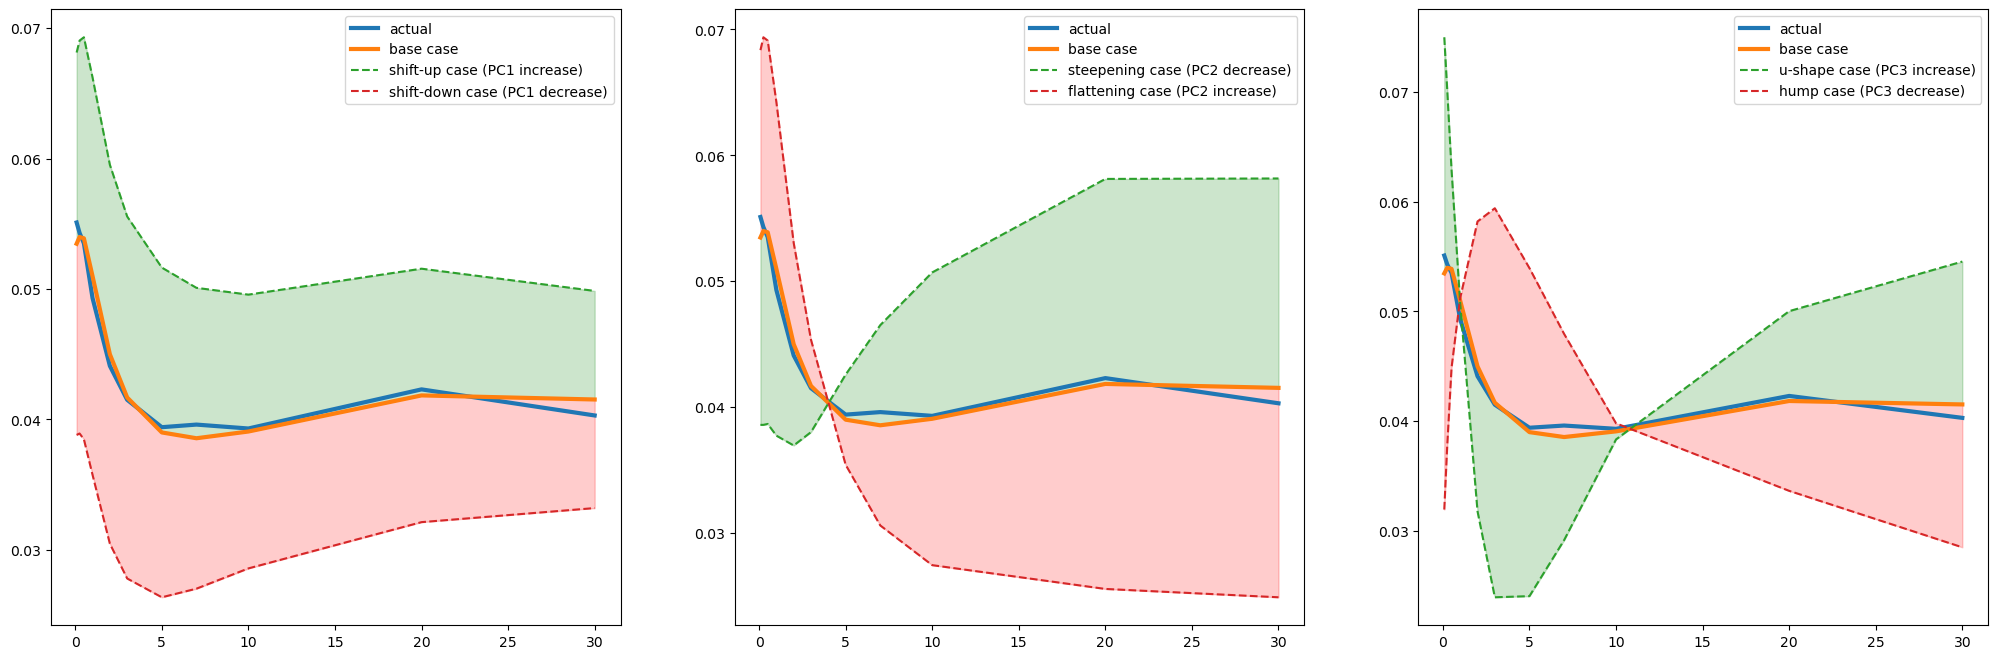

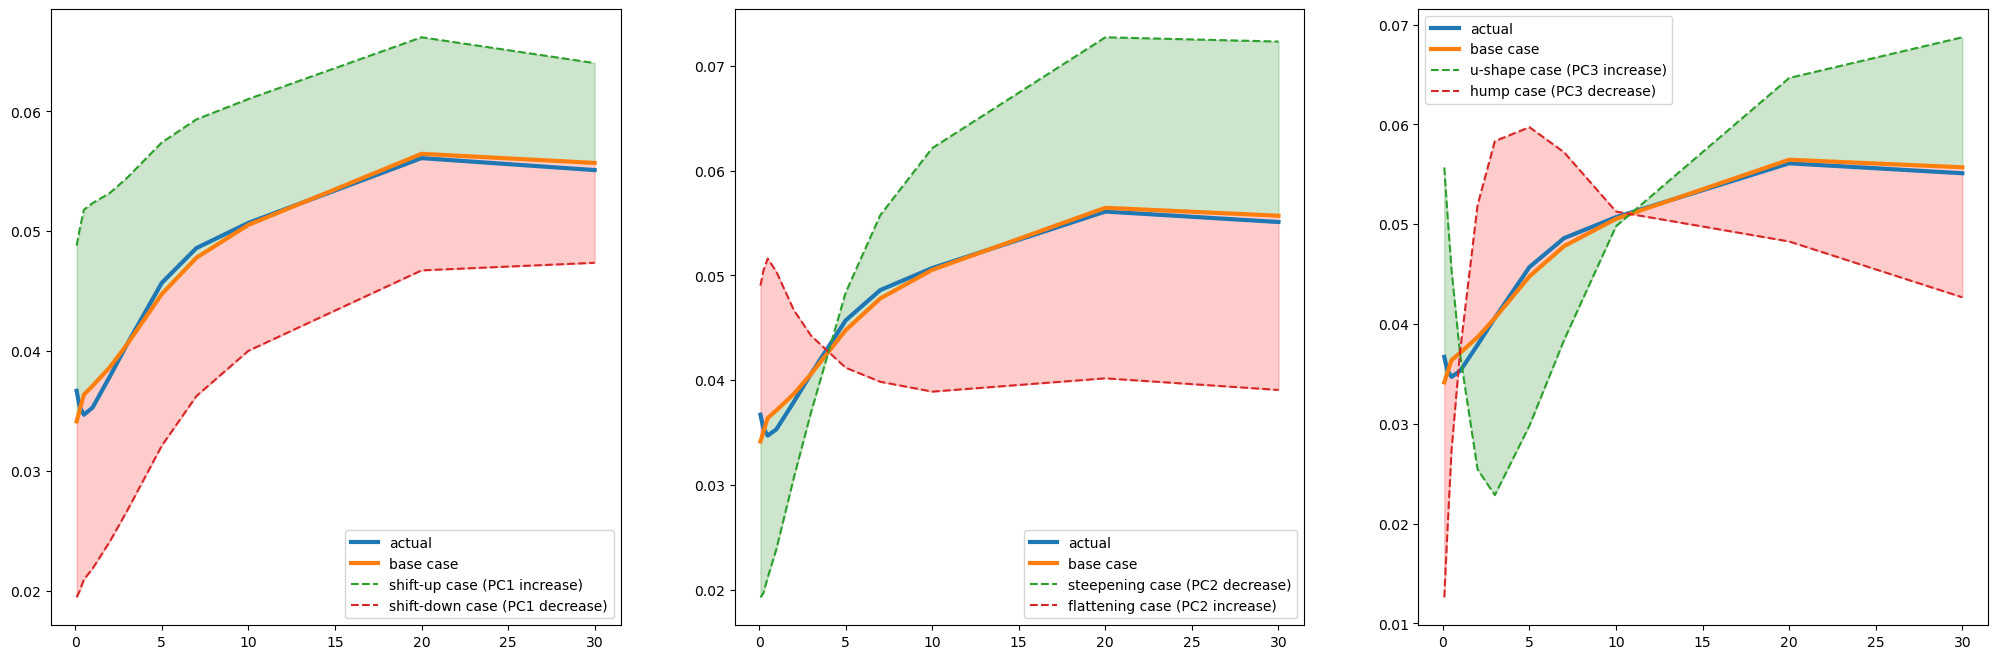

In [175]:
# create stress testing scenarios of change in one factors, holding else constant
# base case PCA fitted yc
yc_pred, _, _          = get_PCA_pred(yc, yc, PC1_shift=0,  PC2_shift=0,  PC3_shift=0)
# fitted yc with shifts up and down
yc_pred_up, _, _       = get_PCA_pred(yc, yc, PC1_shift=3,  PC2_shift=0,  PC3_shift=0)
yc_pred_down, _, _     = get_PCA_pred(yc, yc, PC1_shift=-3, PC2_shift=0,  PC3_shift=0)
# fitted yc with upward/downward slopes
yc_pred_upward, _, _   = get_PCA_pred(yc, yc, PC1_shift=0,  PC2_shift=-3, PC3_shift=0)
yc_pred_downward, _, _ = get_PCA_pred(yc, yc, PC1_shift=0,  PC2_shift=3,  PC3_shift=0)
# fitted yc with hump/inverted curvature
yc_pred_hump, _, _     = get_PCA_pred(yc, yc, PC1_shift=0,  PC2_shift=0,  PC3_shift=3)
yc_pred_ushape, _, _   = get_PCA_pred(yc, yc, PC1_shift=0,  PC2_shift=0,  PC3_shift=-3)

def plot_yc_test(pick_yc):
    fig,ax = plt.subplots(1,3, figsize=(25,8))
    yc.loc[pick_yc].plot(label='actual', ax=ax[0], lw=3)
    yc_pred.loc[pick_yc].plot(label='base case', ax=ax[0], lw=3)
    yc_pred_up.loc[pick_yc].plot(label='shift-up case (PC1 increase)', ax=ax[0], ls='--')
    yc_pred_down.loc[pick_yc].plot(label='shift-down case (PC1 decrease)', ax=ax[0], ls='--')
    ax[0].fill_between(yc_pred.loc[pick_yc].index, yc_pred.loc[pick_yc], yc_pred_up.loc[pick_yc], alpha=0.2, color='green')
    ax[0].fill_between(yc_pred.loc[pick_yc].index, yc_pred.loc[pick_yc], yc_pred_down.loc[pick_yc], alpha=0.2, color='red')
    ax[0].legend();

    yc.loc[pick_yc].plot(label='actual', ax=ax[1], lw=3)
    yc_pred.loc[pick_yc].plot(label='base case', ax=ax[1], lw=3)
    yc_pred_upward.loc[pick_yc].plot(label='steepening case (PC2 decrease)', ax=ax[1], ls='--')
    yc_pred_downward.loc[pick_yc].plot(label='flattening case (PC2 increase)', ax=ax[1], ls='--')
    ax[1].fill_between(yc_pred.loc[pick_yc].index, yc_pred.loc[pick_yc], yc_pred_upward.loc[pick_yc], alpha=0.2, color='green')
    ax[1].fill_between(yc_pred.loc[pick_yc].index, yc_pred.loc[pick_yc], yc_pred_downward.loc[pick_yc], alpha=0.2, color='red')
    ax[1].legend();

    yc.loc[pick_yc].plot(label='actual', ax=ax[2], lw=3)
    yc_pred.loc[pick_yc].plot(label='base case', ax=ax[2], lw=3)
    yc_pred_ushape.loc[pick_yc].plot(label='u-shape case (PC3 increase)', ax=ax[2], ls='--');
    yc_pred_hump.loc[pick_yc].plot(label='hump case (PC3 decrease)', ax=ax[2], ls='--')
    ax[2].fill_between(yc_pred.loc[pick_yc].index, yc_pred.loc[pick_yc], yc_pred_ushape.loc[pick_yc], alpha=0.2, color='green')
    ax[2].fill_between(yc_pred.loc[pick_yc].index, yc_pred.loc[pick_yc], yc_pred_hump.loc[pick_yc], alpha=0.2, color='red')
    ax[2].legend();
    
# downward sloping case
pick_yc = '2023-12-19'
plot_yc_test(pick_yc)

# upward sloping case
pick_yc = '2001-07-31'
plot_yc_test(pick_yc)

In [176]:
# created by PC1 +3
up_YC = yc_pred_up.loc[pick_yc]
up_level = round(up_YC[10], 2)
# created by PC1 -3
down_YC = yc_pred_down.loc[pick_yc]
down_level = round(down_YC[10], 2)
print('classical measure: level')
print('shift up (PC1 +3)', up_level, 'shift down (PC1 -3)', down_level)

# created by PC2 -3
upward_YC = yc_pred_upward.loc[pick_yc]
upward_slope = round(upward_YC[10] - upward_YC[0.5], 2)
# created by PC2 +3
downward_YC = yc_pred_downward.loc[pick_yc]
downward_slope = round(downward_YC[10] - downward_YC[0.5], 2)
print('classical measure: slope')
print('upward sloping (PC2 -3)', upward_slope, 'downward sloping (PC2 +3)', downward_slope)

# upward sloping case
pick_yc = '2001-07-31'
# created by PC3 +3
humped_YC = yc_pred_hump.loc[pick_yc]
humped_curvature = round(humped_YC[10] + humped_YC[0.5] - 2*humped_YC[5], 2)
# created by PC3 -3
ushape_YC = yc_pred_ushape.loc[pick_yc]
ushape_curvature = round(ushape_YC[10] + ushape_YC[0.5] - 2*ushape_YC[5], 2)
print('classical measure: curvature')
print('humped (PC3 +3)', humped_curvature, 'u-shape (PC3 -3)', ushape_curvature)

classical measure: level
shift up (PC1 +3) 0.06 shift down (PC1 -3) 0.04
classical measure: slope
upward sloping (PC2 -3) 0.04 downward sloping (PC2 +3) -0.01
classical measure: curvature
humped (PC3 +3) -0.04 u-shape (PC3 -3) 0.04


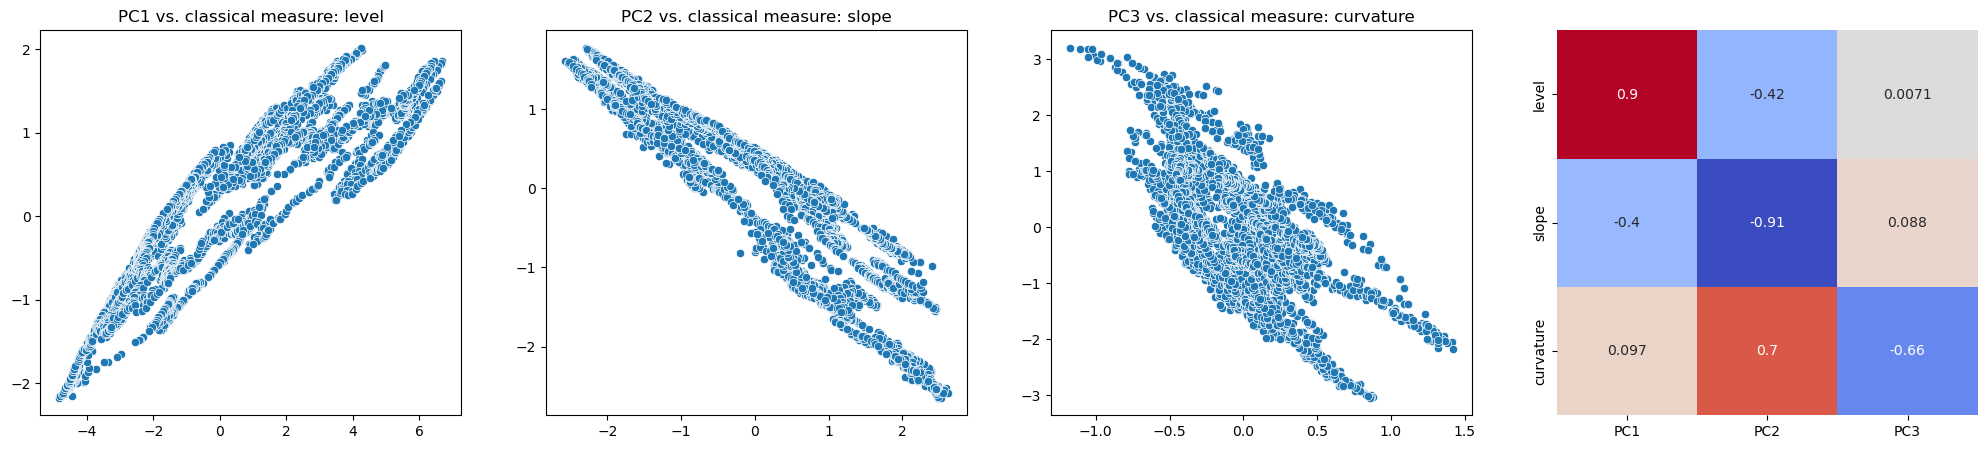

In [177]:
### PCA measure: 
# PC1 (level): increase --> shift up, decrease --> shift down
# PC2 (slope): decrease --> upward sloping, increase --> downward sloping
# PC3 (curvature): increase --> humped, decrease --> u-shaped

### classical measure
# level: '10Y', higher --> shift up, lower --> shift down
# slope: '10Y - 6M', higher gap --> upward sloping (steepening), lower gap --> downward sloping (flattening)
# curvature: '10Y + 6M - 2*5Y', higher --> u-shaped, lower --> humped

# Hence, it must be that:
# PC1 and classical level are positively related,
# PC2 and classical slope are negatively related, 
# PC3 and classical curvature are negatively related.

PC_factors = pd.DataFrame(YC_pca[['PC1','PC2','PC3']].values, columns=['PC1','PC2','PC3'], index=yc.index)
factors_comp = pd.concat([PC_factors,classical_factors], axis=1)
fig,ax = plt.subplots(1,4, figsize=(25,5))
sns.scatterplot(x=factors_comp['PC1'].values, y=factors_comp['level'].values, ax=ax[0])
ax[0].set_title('PC1 vs. classical measure: level')
sns.scatterplot(x=factors_comp['PC2'].values, y=factors_comp['slope'].values, ax=ax[1])
ax[1].set_title('PC2 vs. classical measure: slope')
sns.scatterplot(x=factors_comp['PC3'].values, y=factors_comp['curvature'].values, ax=ax[2]);
ax[2].set_title('PC3 vs. classical measure: curvature');

sns.heatmap(factors_comp.corr().loc[['level','slope','curvature'],['PC1','PC2','PC3']], 
            cmap='coolwarm', 
            annot=True, ax=ax[3], cbar=False);

### PC factor sign adjustments before running 3 factor model regression
- make PC factor's directional effect consistent with the classical factors (so that interpretation is consistent) by:
    - leaving PC1, positively related with level (consistent with classical interpretation)
    - multiply PC2 by -1, previously negatively related with slope (now increase in PC2 means increase in slope)
    - multiply PC3 by -1, previously negatively related with curvature (now increase in PC3 means inverted, u-shaped)

Before and After adjusting factors for signs

maturity impact on PC factors now match maturity impact on classical factors;
1) all maturities have positive contrbution to level factor 
   (classical level factor: 10Y)
2) LT maturities are positively related with slope factor whereas ST maturities are negatively related 
   (classical slope factor = 10Y-6M)
3) ST and LT maturities are positively related with U-shaped curvature while MT maturities are negatively related 
   to U-shaped curvature (positively related to hump)
   (classical curvature factor = 6M + 10Y - 2*5Y)



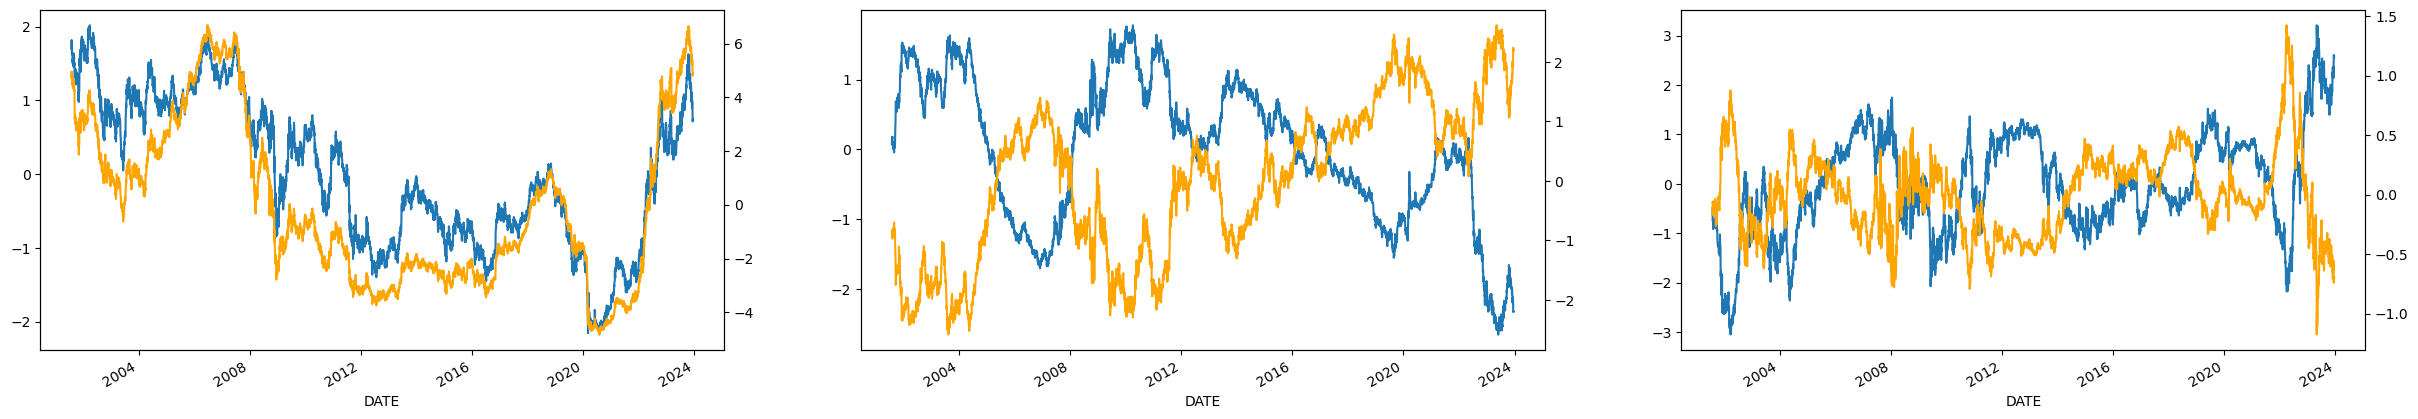

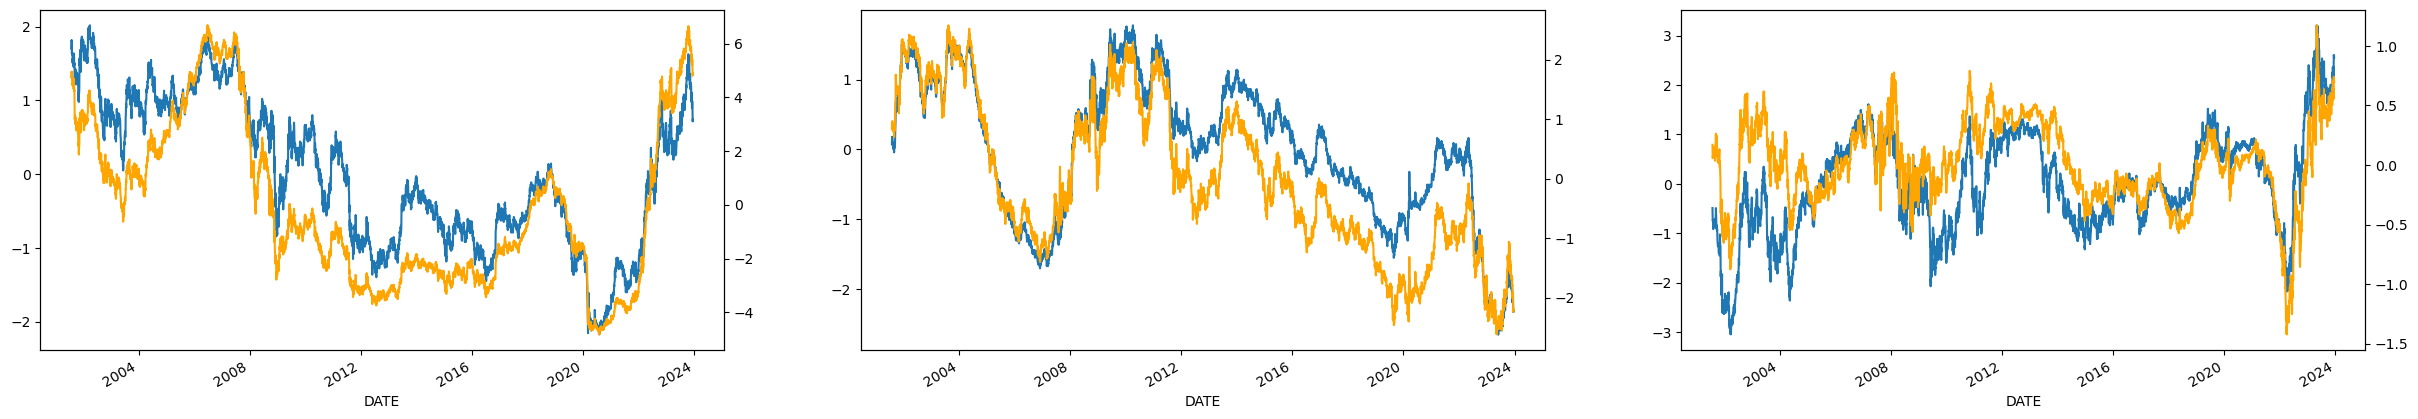

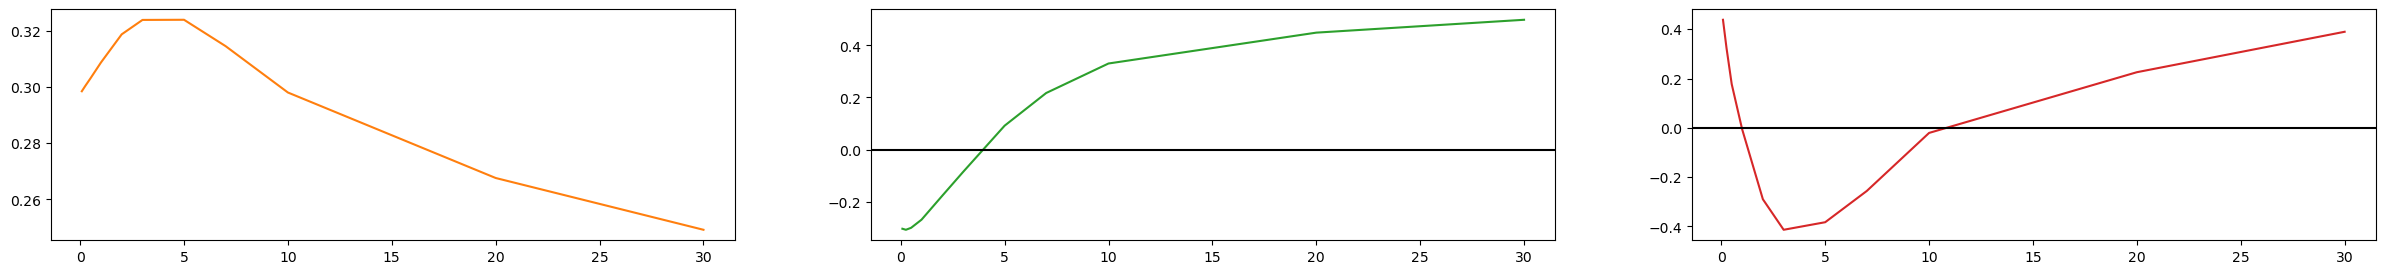

In [178]:
# shaping risk factors over maturities: cross-sectional YC
factors_m = factor_load[['PC1','PC2','PC3']].set_axis(['level','slope','curvature'],axis=1)
# shaping risk factors over time: time series of yields
factors_t = pd.DataFrame(YC_pca[['PC1','PC2','PC3']].values, 
                         index=yc.index).set_axis(['level','slope','curvature'],axis=1)

def plot_factors():
    fig,ax=plt.subplots(1,3, figsize=(30,5))
    ax1=ax[0].twinx()
    classical_factors['level'].plot(ax=ax[0])
    factors_t['level'].plot(ax=ax1, c='orange')
    ax2=ax[1].twinx()
    classical_factors['slope'].plot(ax=ax[1])
    factors_t['slope'].plot(ax=ax2, c='orange')
    ax3=ax[2].twinx()
    classical_factors['curvature'].plot(ax=ax[2])
    factors_t['curvature'].plot(ax=ax3, c='orange')

print('Before and After adjusting factors for signs')
# PCA factors comes in opposite signs
plot_factors()

# adjust signs for better interpretability
factors_m[['slope','curvature']] = factors_m[['slope','curvature']] * -1
factors_t[['slope','curvature']] = factors_t[['slope','curvature']] * -1

plot_factors()

fig,ax=plt.subplots(1,3, figsize=(30,3))
factors_m['level'].plot(ax=ax[0], c='C1', label='coefficients of maturities on level factor')
factors_m['slope'].plot(ax=ax[1], c='C2', label='coefficients of maturities on slope factor')
factors_m['curvature'].plot(ax=ax[2], c='C3', label='coefficients of maturities on curvature factor');
for i in range(1,3):
    ax[i].axhline(0, c='black')
print('''
maturity impact on PC factors now match maturity impact on classical factors;
1) all maturities have positive contrbution to level factor 
   (classical level factor: 10Y)
2) LT maturities are positively related with slope factor whereas ST maturities are negatively related 
   (classical slope factor = 10Y-6M)
3) ST and LT maturities are positively related with U-shaped curvature while MT maturities are negatively related 
   to U-shaped curvature (positively related to hump)
   (classical curvature factor = 6M + 10Y - 2*5Y)
''')

### PCA-implied yield curve (predicted)

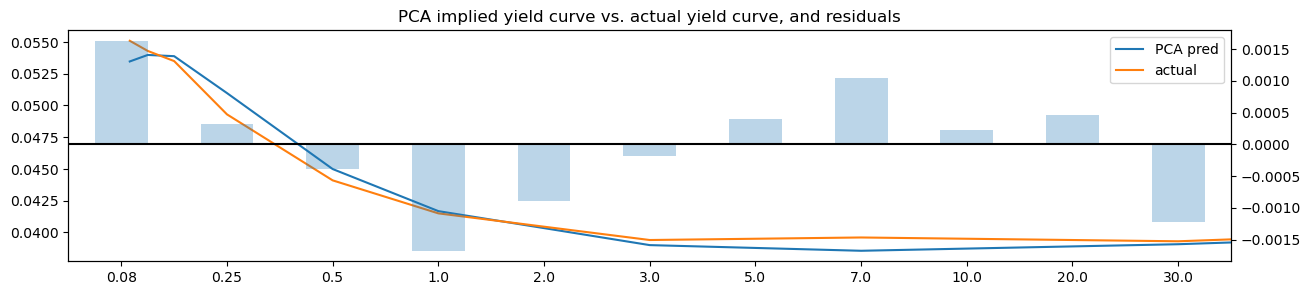

In [179]:
yc_pred, _, _ = get_PCA_pred(yc, yc, resid=False, n_components=3)

fig,ax = plt.subplots(figsize=(15,3))
ax1 = ax.twinx()
resid.iloc[-1].plot(kind='bar', label='resid', ax=ax1, alpha=0.3)
yc_pred.iloc[-1].plot(label='PCA pred', ax=ax)
yc.iloc[-1].plot(label='actual', ax=ax)
ax1.axhline(0, c='black')
ax.set_title('PCA implied yield curve vs. actual yield curve, and residuals')
ax.legend();

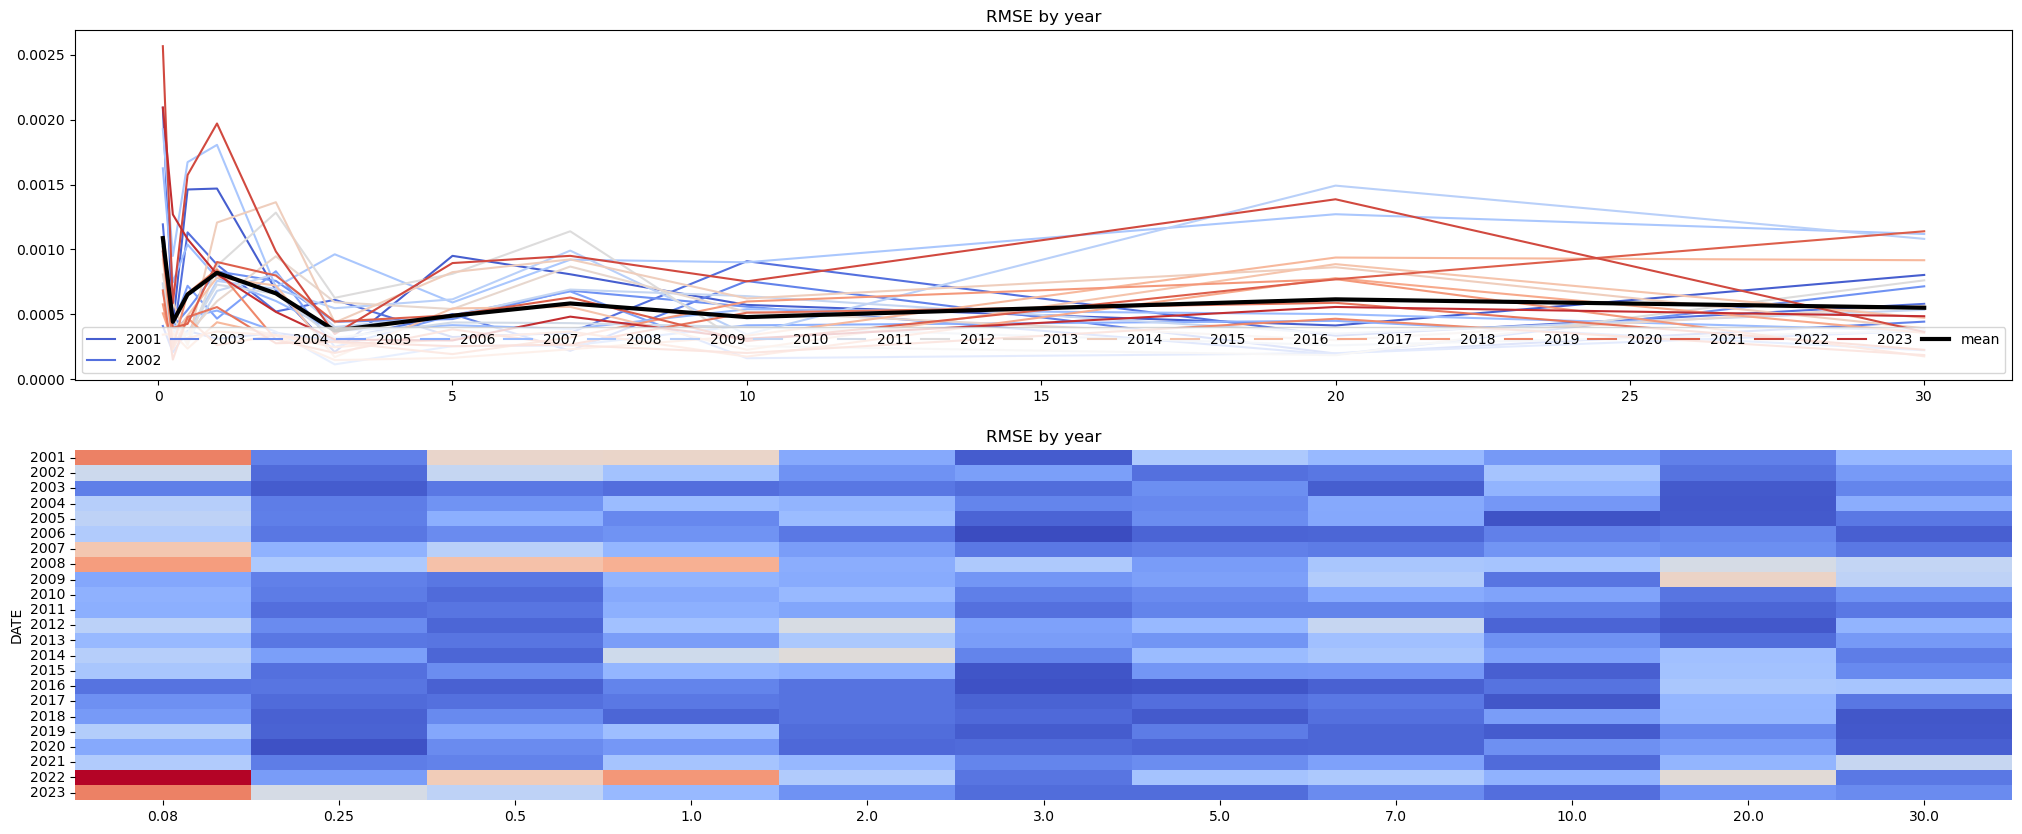

In [180]:
rmse_by_year = (resid**2).groupby(resid.index.year).mean() ** 0.5

fig,ax = plt.subplots(2,1, figsize=(25,10))
sns.lineplot(rmse_by_year.T, dashes=False, palette='coolwarm', ax=ax[0]);
ax[0].plot(rmse_by_year.mean(), lw=3, c='black', label='mean')
ax[0].legend(loc="lower left", mode = "expand", ncol = len(rmse_by_year));
ax[0].set_title('RMSE by year')
sns.heatmap(rmse_by_year, cmap='coolwarm', ax=ax[1], cbar=False);
ax[1].set_title('RMSE by year');

### Using PCA to predict: In-sample (Train) vs. Out-of-sample (Test)

train data: 2001-07-31 00:00:00 ~ 2019-06-28 00:00:00, (4480)
test data: 2019-07-01 00:00:00 ~ 2023-12-19 00:00:00, (1120)
Total len: 5600, train + test = 5600


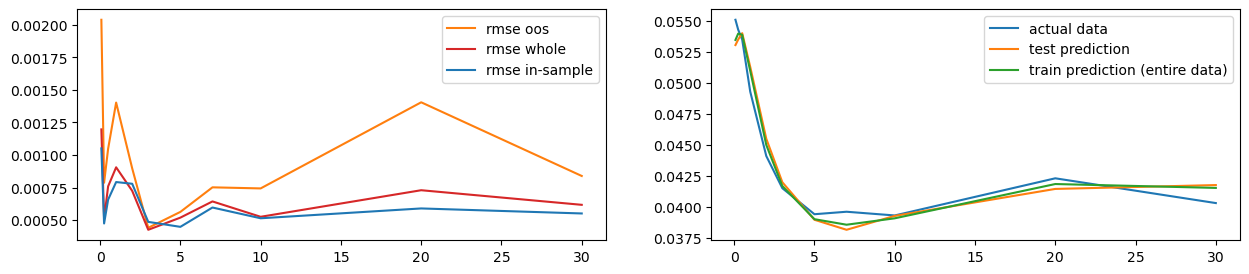

In [181]:
# in sample and out of sample PCA
yc_train, yc_test = TS_train_test_split(yc, test_size=0.2)
yc_pred_train, yc_pred_test, _ = get_PCA_pred(yc_train, yc_test, resid=False, n_components=3)
yc_resid_train, yc_resid_test, _ = get_PCA_pred(yc_train, yc_test, resid=True, n_components=3)

# in sample PCA on the entire data
yc_pred, _, _ = get_PCA_pred(yc, yc, resid=False, n_components=3)
yc_resid, _, _ = get_PCA_pred(yc, yc, resid=True, n_components=3)

rmse_train = (yc_resid_train**2).mean() ** 0.5
rmse_test = (yc_resid_test**2).mean() ** 0.5
rmse_whole = (yc_resid**2).mean() ** 0.5

fig,ax = plt.subplots(1,2, figsize=(15,3))
rmse_test.plot(label='rmse oos', color='tab:orange', ax=ax[0])
rmse_whole.plot(label='rmse whole', color='tab:red', ax=ax[0])
rmse_train.plot(label='rmse in-sample', ax=ax[0])
ax[0].legend();

yc_test.iloc[-1].plot(label='actual data', ax=ax[1])
yc_pred_test.iloc[-1].plot(label='test prediction', ax=ax[1])
yc_pred.iloc[-1].plot(label='train prediction (entire data)', ax=ax[1])
ax[1].legend();